# Regression Model with Seasonal ARIMA

- ARIMA = Autoregressive Integrated Moving Average. More details in [6]
- (Seasonal) ARIMA errors ie: the (S)ARIMAX [3]
- Since we are using (S)ARIMAX, we may also implicitly use past values of the dependent variable PT08_S4_NO2 and past errors of the model as additional regression variables [3]
- **Regression Goal**: Build a regression model to predict the hourly value of the PT08_S4_NO2 variable [3]
- **Regression Strategy**: The variables are [3]
    - X, a matrix regression (independent) variable (IV) -- Temperature (T) and Absolute Humidity (AH)
    - y, a dependent variable -- (PT08_S4_NO2)
    - columns in data wrt variables -- T, AH, PT08_S4_NO2
    - SIDE NOTE: (IV) vs (DV): causes the effect on the (DV) vs it depends on the (IV) [4]

# Imports + Load Data

In [1]:
# !pip install statsmodels

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as statsmodel
from statsmodels.regression import linear_model
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA as ARIMA

In [3]:
BASE = '/Users/brinkley97/Documents/development/'
path_to_dataset = 'book-forecasting_and_control_by_4_Gs/datasets/'
name_of_dataset = 'air_quality_uci_mod.csv'
dataset = BASE + path_to_dataset + name_of_dataset
air_quality_df = pd.read_csv(dataset, header=0)
air_quality_df

,DateTime,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
0,03-10-04 18:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,03-10-04 19:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,03-10-04 20:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,03-10-04 21:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,03-10-04 22:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,04-04-05 10:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
7340,04-04-05 11:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
7341,04-04-05 12:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
7342,04-04-05 13:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


# 1. Prepare the data
- [ ] 1.1 Convert the dateTime column to a pandas DateTime column and set it as the index of the DataFrame. Learn more at [7][8].
- [ ] 1.2 Set the frequency attribute of the index to Hourly.
    - The reasoning is because we want to make predictions at new hours.
    - Doing this will create empty rows as there may NOT be a hourly measurement at that time in the original data. [Ex](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html)
    - [ ] Fill empty (nan) cells with the mean of the corresponding column 
- [ ] 1.3 Verify that there are no empty cells in any column. The output should be all zeroes.
- [ ] 1.4 Create the training and the test data sets

## 1.1

In [4]:
air_quality_df['DateTimeIndex'] = pd.to_datetime(air_quality_df.loc[0:, "DateTime"])
air_quality_df

,DateTime,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH,DateTimeIndex
0,03-10-04 18:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004-03-10 18:00:00
1,03-10-04 19:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004-03-10 19:00:00
2,03-10-04 20:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004-03-10 20:00:00
3,03-10-04 21:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004-03-10 21:00:00
4,03-10-04 22:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,04-04-05 10:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568,2005-04-04 10:00:00
7340,04-04-05 11:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119,2005-04-04 11:00:00
7341,04-04-05 12:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406,2005-04-04 12:00:00
7342,04-04-05 13:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139,2005-04-04 13:00:00


In [5]:
air_quality_df.set_index(['DateTimeIndex'])

,DateTime,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
DateTimeIndex,,,,,,,,,,,,,,
2004-03-10 18:00:00,03-10-04 18:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2004-03-10 19:00:00,03-10-04 19:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2004-03-10 20:00:00,03-10-04 20:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
2004-03-10 21:00:00,03-10-04 21:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
2004-03-10 22:00:00,03-10-04 22:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,04-04-05 10:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
2005-04-04 11:00:00,04-04-05 11:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
2005-04-04 12:00:00,04-04-05 12:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406


In [6]:
# new index is NOT set
# air_quality_df

In [7]:
air_quality_df.set_index(['DateTimeIndex'], inplace=True)

In [8]:
# new index is set
air_quality_df

,DateTime,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
DateTimeIndex,,,,,,,,,,,,,,
2004-03-10 18:00:00,03-10-04 18:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2004-03-10 19:00:00,03-10-04 19:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2004-03-10 20:00:00,03-10-04 20:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
2004-03-10 21:00:00,03-10-04 21:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
2004-03-10 22:00:00,03-10-04 22:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,04-04-05 10:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
2005-04-04 11:00:00,04-04-05 11:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
2005-04-04 12:00:00,04-04-05 12:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406


## 1.2 - 1.3

- Convert time series to specified frequency with pd [df]`.asfreq()`
- Note the #rows will increase

In [9]:
air_quality_df = air_quality_df.asfreq('H')
air_quality_df

,DateTime,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
DateTimeIndex,,,,,,,,,,,,,,
2004-03-10 18:00:00,03-10-04 18:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,03-10-04 19:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,03-10-04 20:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,03-10-04 21:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,03-10-04 22:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,04-04-05 10:00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,04-04-05 11:00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,04-04-05 12:00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406


In [10]:
air_quality_df = air_quality_df.fillna(air_quality_df.mean())

In [11]:
# NOT all 0s so need to fix
air_quality_df.isin([np.nan, np.inf, -np.inf]).sum()

DateTime        2013
CO_GT              0
PT08_S1_CO         0
NMHC_GT            0
C6H6_GT            0
PT08_S2_NMHC       0
NOx_GT             0
PT08_S3_NOx        0
NO2_GT             0
PT08_S4_NO2        0
PT08_S5_O3         0
T                  0
RH                 0
AH                 0
dtype: int64

## 1.4

- Train (90%) and Test (10%)

In [12]:
dataset_len = len(air_quality_df)
# print(dataset_len)
split_data = round(dataset_len*0.9)
# print(split_data)
train_set_end_date = air_quality_df.index[split_data]
# print(len(df_train))
df_train = air_quality_df.loc[air_quality_df.index <= train_set_end_date].copy()
# print(len(df_train))
df_test = air_quality_df.loc[air_quality_df.index > train_set_end_date].copy()
# print(len(df_test))

In [13]:
# train_test_data = [air_quality_df, dataset_len, split_data, train_set_end_date, df_train, df_test]

# 2. Create a Linear Regression model

- [ ] Create model expression
- [ ] Carve out the y and X matrices
- [ ] Fit an Ordinary Least Squares Linear Regression (OLSR) model on the training dataset
    - Is a common technique for estimating the coefficients of linear regression equations
    - Describes the relationship between one or more IV and a DV
    - Formuation with more notes [9] and code from scratch [10] (which code isn't matching results below)
- [ ] Show results and see explanations in [3]
    - My results differ slightly, maybe due to the DateTime col NOT going to 0

In [14]:
# variable = DV (vector y) ~ IV (vector x) + IV (vector x) (so both IV -> Matrix X); find the coef, std err, t, and P>|t|, respectively
expr = 'PT08_S4_NO2 ~ T + AH'

In [18]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
# print(y_train)

In [19]:
# 'fit' method trains the algorithm on the training data, after the model is initialized
olsr_results = linear_model.OLS(y_train, X_train).fit()
olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PT08_S4_NO2   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     2991.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:58:28   Log-Likelihood:                -57736.
No. Observations:                8422   AIC:                         1.155e+05
Df Residuals:                    8419   BIC:                         1.155e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    902.9774      7.820    115.471      0.000     887.648     918.306
T              9.7918      0.423     23.138      0.000       8.962      10.621
AH           384.4853      9.407     40.873      0.000     366.046     402.925
==============================================================================
Omnibus:                     1713.095   Durbin-Watson:                   0.343
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4031.921
Skew:                           1.142   Prob(JB):                         0.00
Kurtosis:                       5.504   Cond. No.                         87.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# olsr_results.params

# Regression errors
olsr_results.resid

DateTimeIndex
2004-03-10 18:00:00    364.491532
2004-03-10 19:00:00    246.847939
2004-03-10 20:00:00    247.059642
2004-03-10 21:00:00    270.838531
2004-03-10 22:00:00    174.072756
                          ...    
2005-02-24 11:00:00    -75.043871
2005-02-24 12:00:00   -118.122566
2005-02-24 13:00:00    -51.676736
2005-02-24 14:00:00    -41.620804
2005-02-24 15:00:00     28.773269
Length: 8422, dtype: float64

# 3. Estimate (S)ARIMA parameters (p, d, q) and m

- [ ] Plot the Auto-correlation (ACF/ACor) of the residual errors
    - [ ] Plot with my ACor functions [5]
- [ ] Summarize ACF plots
- [ ] Difference the time series once (i.e: d = 1)
- [ ] Replot the ACF of the 1 differenced time series of residual erros
- [ ] Difference the time series again (i.e.: d = 2)
- [ ] Replot the ACF of the 2 differenced time series of residual erros
- [ ] Verify that the seasonal period m is 24 hours
    - [ ] Decompose the residual errors of regression into trend, seasonality and noise by using the `seasonal_decompose()` function provided by statsmodels
    - [ ] Plot output from using the `seasonal_decompose()` function
- [ ] Apply a single seasonal difference to our already differenced time series of residual errors

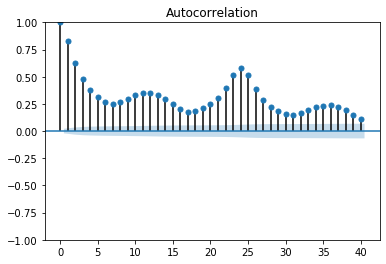

In [24]:
tsa.plot_acf(olsr_results.resid, alpha=0.05)
plt.show()

## SIDE NOTE with My Plots

In [102]:
# %load my_acor_plot
/Users/brinkley97/Documents/development/book-forecasting_and_control_by_4_Gs/part_1/2-autocorrelation_func_and_spectrum_of_stationary_process/exercises/2.4.2.ipynb

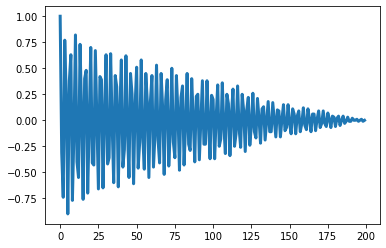

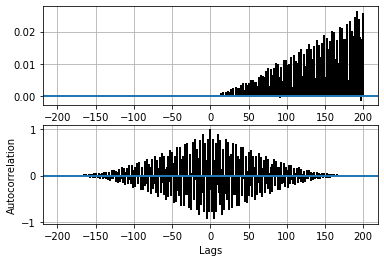

In [103]:
%run "/Users/brinkley97/Documents/development/book-forecasting_and_control_by_4_Gs/part_1/2-autocorrelation_func_and_spectrum_of_stationary_process/exercises/2.4.2.ipynb"

In [148]:
residuals = olsr_results.resid
# residuals.to_dict
list_residuals = residuals.tolist()
ks = range(0, 41)
# print(ks[-1])
lags = range(0, 41)
# print(lags)

def order_lags_and_residuals(lags, list_residuals):

    l = []
    get_res = []
    
    for lag in lags:
        res = list_residuals[lag]
        get_res.append(res)
        l.append(lag)
    return l, get_res

40


In [144]:
l, res = order_lags_and_residuals(lags, list_residuals)

In [145]:
def merge(list1, list2):
     
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

In [146]:
r_ks = merge(l, res)
# r_ks

(None, None)

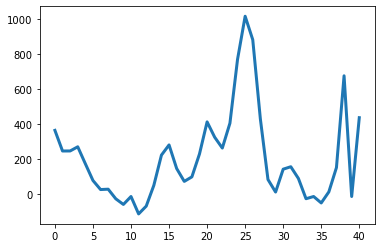

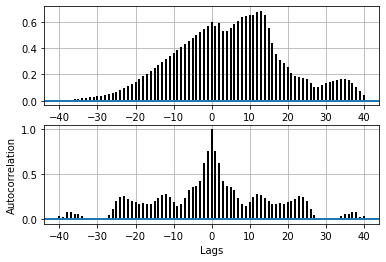

In [147]:
lags = []
autocor = []
len_rks = len(r_ks)
# print(r_ks[0:45])
graph_est_autocor(lags, autocor, r_ks, len_rks)

## END of SIDE NOTE with My Plots

# 4. Build and fit the Regression Model with Seasonal ARIMA errors
- [ ] Fit the SARIMAX model on the training data set (y_train, X_train) 
- [ ] Build and test the SARIMAX model
- [ ] Simplify our model by setting Q to 0 (i.e: we’ll try a SARIMAX(1,1,0)(0,1,0)24 model)

# 5. Prediction
- [ ] Predict the value of the y (PT08_S4_NO2) for the next 24 hours beyond the end of the training data set
- [ ] Call the `get_forecast` method to get the out of sample forecasts
- [ ] Plot the actual value y_test from the test data set

# References

1. BOOK: [Time Series Analysis: Forecasting and Control, 5th Edition](https://www.wiley.com/en-us/Time+Series+Analysis:+Forecasting+and+Control,+5th+Edition-p-9781118675021)
2. BOOK: [Time Series Analysis, Regression and Forecasting with tutorials in Python](https://timeseriesreasoning.com/)
3. WEBSITE: [Introduction to Regression With ARIMA Errors Model](https://timeseriesreasoning.com/contents/regression-with-arima-errors-model/)
4. PAPER: [A Survey of Multimodal Probabilistic Learning by Detravious](https://detraviousjbrinkley.notion.site/A-Survey-of-Multimodal-Probabilistic-Learning-for-Human-Communication-and-Emotion-Recognition-d40cab0081024276b876ae0de4204dc7) (in construction)
5. SOFTWARE: [Calculate ACov and ACor](https://github.com/Brinkley97/book-forecasting_and_control/blob/main/part_1/2-autocorrelation_func_and_spectrum_of_stationary_process/exercises/2.4.3.ipynb) by Detravious
6. NOTES: [Forecasting](https://detraviousjbrinkley.notion.site/4-Authors-of-Time-Series-Analysis-Forecasting-and-Control-afdbdf02a6254cdba15d5379d7ac578c) by Detravious
7. SOFTWARE: [DateTime Notes with Code from CH 12 Time Series Analysis from Pandas Cookbook](https://github.com/Brinkley97/tutorial-python_libraries/blob/main/pandas/dateTime.ipynb) by Detravious
8. SOFTWARE: [Exploring Dates and Times - Python vs Pandas Notes with Code](https://github.com/Brinkley97/tutorial-python_libraries/blob/main/pandas/dateTime2.ipynb) by Detravious 
9. NOTES: [Linear Regressions](https://detraviousjbrinkley.notion.site/Linear-Regression-aka-Numerical-8063ecf70d41418aae0057a9030941d2) by Detravious
10. SOFTWARE: [Ordinary Least Squares (OLS)](https://github.com/Brinkley97/book-forecasting_and_control/blob/main/part_1/4-linear_nonstationary_models/ordinaryLeastSquares.ipynb)